In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Time Series
<!-- requirement: images/time_series_CV.png -->
<!-- requirement: data/arima_model.pkl -->
<!-- requirement: data/co2_weekly_mlo.txt -->

A time series is a sequence of measurements of a variable made over time. The usually application of machine learning to a time series is to use past behavior to make forecasts. Since the time series are usually continuous values, forecasting is a supervised regression problem. Time series differ from the "standard" regression problems studied earlier because observations are _usually_ not independent and the only piece of data we have is the signal itself. We want to take advantage of the temporal nature of the data without the knowledge of the forces that caused those values. The general approach when working with a time series is to

1. Plot the time series; notice any overall trends and seasonality.
1. Detrend the time series by removing drift and seasonality.
1. Fit a baseline model and calculate the residuals.
1. Analyze the resulting residuals and generate features from the residuals.
1. Train a machine learning model to forecast/predict residuals and add back the baseline model.

For this notebook, we will be analyzing the atmospheric carbon dioxide levels measured from the Mauna Loa Observatory in Hawaii. More information about the data can be found [here](https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html).

## Components of a time series

We can model our time series as having three components,

$$ y(t) = \mathrm{drift} + \mathrm{seasonal} + \mathrm{noise}. $$

The components are defined as

1. **Drift**: An overall trend present in the time series. An example of a drift model is
$$ y(t) = \mu t. $$
Other commonly applied drift models are quadratic and exponential.

1. **Seasonality**: A periodic behavior existing in the time series. For a given frequency $f$, a common model is
$$ y(t) = A\sin(2\pi ft) + B\cos(2\pi ft). $$

1. **Noise**: The part of the time series remaining after removing drift and seasonality. It is the residual of a model containing drift and seasonality.

Our approach will be to identify the first two terms to create a baseline model, leaving behind the residuals or noise. This [link](https://people.duke.edu/~rnau/whatuse.htm) provides a list of different transformations that are commonly applied when analyzing time series.

** Questions**
* What are some examples of drift in real time series?
* What are some examples of seasonality in real time series?

## Cross-validation of time series data

Since observations are not independent and we want to use past data to predict future values, we need to apply slightly different approach when training and testing a machine learning model. Given the temporal nature of the data, we need to preserve order and have the training set occur prior to the test set. For cross-validation, two common methods are used, sliding and forward chaining.

* **Sliding Window**: The model is trained with data in a fixed window size and tested with data in the following window of the same size. Then the window _slides_ where the previous test data becomes the training data and repeated for the number of chosen folds.

* **Forward Chaining**: The model is _initially_ trained/tested with windows of the same size as the sliding window method. However, for each subsequent fold, the training window increases in size, encompassing both the previous training data and test data. The new test window once again follows the training window but stays the same length. 

![time_series_CV](images/time_series_CV.png)

In `scikit-learn`, the forward chaining method is available in `sklearn.model_selection.TimeSeriesSplit`. See below for an example of using forward chaining with `GridSearchCV`. See this [link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) for more info on the usage.

In [3]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

regressor = Ridge()
param_grid = {"alpha": np.logspace(-2, 2, 100)}
ts_cv = TimeSeriesSplit(5) # 5-fold forward chaining
grid_search = GridSearchCV(regressor, param_grid, cv=ts_cv, n_jobs=2)

In [4]:
TimeSeriesSplit?

## Stationary signal

Ideally, the resulting time series of the residuals will be **stationary**. A stationary signal or process is one in which statistical values such as the mean do not change with time. For our purposes, we are concerned about the special case where the mean, variance, and autocorrelation (explained more later) are not a function of time. This special case is called weakly stationary. Transforming a time series into a stationary process is crucial for time series analysis because a large number of analysis tools assume the process is stationary. It is easy to predict future values if things like the mean and variance stay the same with time. Consider a time series where new values are dependent on the past time series value and a random, uncorrelated noise $\epsilon_t$.

$$
y_t = \rho y_{t-1} + \epsilon_t.
$$

The parameter $\rho$ scales the contribution of the past value. If $\epsilon_t$ is uncorrelated and has mean zero, it is referred to as **white noise**. If the values are sampled from a normal distribution, the white noise is then called **white Gaussian noise**. The following visualization allows you to scale the contribution of past values by adjusting $\rho$. Notice the signal is stationary when $\rho < 1$ but is no longer stationary when $\rho=1$.

In [6]:
from ipywidgets import interact, FloatSlider

def plot_signal(rho=0):
    n = 1000
    np.random.seed(0)

    eps = np.random.randn(1000)
    y = np.zeros(n)
    y[0] = eps[0]
    var = np.zeros(n)
    
    for i in range(1, n):
        y[i] = rho*y[i-1] + eps[i]
        var[i] = y[:i].var()

    plt.subplot(211)
    plt.plot(y)
    plt.ylabel('y')

    plt.subplot(212)
    plt.plot(var)
    plt.ylabel('$\sigma_y$')    
    plt.plot(var)

interact(plot_signal, rho=FloatSlider(min=0, max=1, value=0, step=0.01, description='$\\rho$'));

interactive(children=(FloatSlider(value=0.0, description='$\\rho$', max=1.0, step=0.01), Output()), _dom_class…

The case when $\rho=1$ is called a one-dimensional [random walk](https://en.wikipedia.org/wiki/Random_walk). A random walk is a stochastic/random process that describes the location of an object from successive random steps, random in both direction and size. The equation $y_t = y_{t-1} + \epsilon_t$ is a random walk because the position at time $t$ is some random distance from the previous location $y_{t-1}$. There have been extensive research on random walk processes since they occur in a wide range of subjects, from financial models to particle diffusion. There are two main consequences of having residuals as white noise.

1. You cannot predict/forecast future values because what is left is uncorrelated noise.
1. You have an adequate time series model since there is no signal left to model.

## Modeling Drift

Let's load the atmospheric CO2 data set using pandas and plot the time series. The data set has weekly measurements but there are some missing values, denoted by `-999.99`. We will need to replace those missing values and create timestamps from the date info.

In [7]:
# load data set
columns = ['year', 'month', 'day', 'decimal date', 'molfrac', 'days', '1 yr ago', '10 yrs ago', 'since 1880']
df = pd.read_csv('data/co2_weekly_mlo.txt', sep='\s+', header=None, names=columns, na_values=-999.99)

# create timestamp indices
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.set_index('decimal date')

# replace missing values
df['molfrac'] = df['molfrac'].fillna(method='ffill')

df.head()

,year,month,day,molfrac,days,1 yr ago,10 yrs ago,since 1880,date
decimal date,,,,,,,,,
1974.3795,1974,5,19,333.34,6,NaN,NaN,50.36,1974-05-19
1974.3986,1974,5,26,332.95,6,NaN,NaN,50.06,1974-05-26
1974.4178,1974,6,2,332.32,5,NaN,NaN,49.57,1974-06-02
1974.4370,1974,6,9,332.18,7,NaN,NaN,49.63,1974-06-09
1974.4562,1974,6,16,332.37,7,NaN,NaN,50.07,1974-06-16


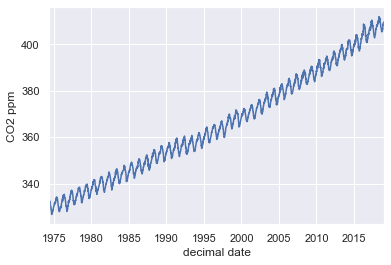

In [8]:
CO2 = df['molfrac']
CO2.plot()
plt.ylabel('CO2 ppm');

**Questions**

* What are some behaviors do you observe in the time series?
* What model would you pose to remove the drift?

Atmospheric CO2 levels have been consisting increasing at a slightly superlinear fashion. While the choice of drift is somewhat subjective, we will use a quadratic fit. The quadratic features will be provided from the `PolynomialFeatures` transformer. Let's create a simple model that only captures the drift; we will worry about the seasonality later. We will perform a train/test split at the year 2010 and define some functions and classes to help with the analysis.

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class IndexSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        """Return indices of a data frame for use in other estimators."""
        pass
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df):
        indices = df.index
        return indices.values.reshape(-1, 1)

In [10]:
def ts_train_test_split(df, cutoff, target):
    """Perform a train/test split on a data frame based on a cutoff date."""
    
    ind = df.index < cutoff
    
    df_train = df.loc[ind]
    df_test = df.loc[~ind]
    y_train = df.loc[ind, target]
    y_test = df.loc[~ind, target]
    
    return df_train, df_test, y_train, y_test

def plot_results(df, y_pred):
    """Plot predicted results and residuals."""
    
    CO2.plot();
    plt.plot(df.index, y_pred, '-r');
    plt.xlabel('year')
    plt.ylabel('CO2 ppm')
    plt.legend(['true', 'predicted']);
    plt.show();

    plt.plot(resd)
    plt.xlabel('year')
    plt.ylabel('residual')

Test set R^2: 0.761966


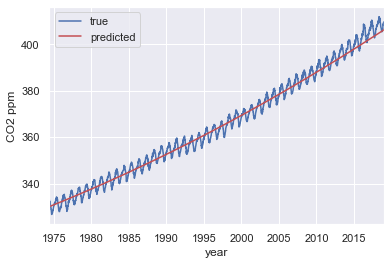

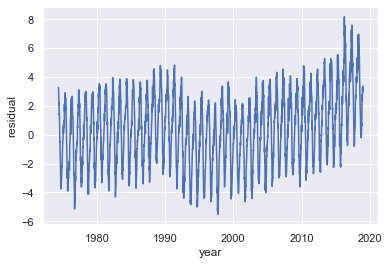

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# perform train/test split
cutoff = 2010
df_train, df_test, y_train, y_test = ts_train_test_split(df, cutoff, 'molfrac')

# construct and train pipeline
time = IndexSelector()
poly = PolynomialFeatures(degree=2)
lr = LinearRegression()
pipe = Pipeline([('indices', time),
                 ('drift', poly),
                 ('regressor', lr)])
pipe.fit(df_train, y_train)

# make predictions
y_pred = pipe.predict(df)
resd = CO2 - y_pred
print("Test set R^2: {:g}".format(pipe.score(df_test, y_test)))
plot_results(df, y_pred)

The residuals exhibit a periodic behavior; our next task is to remove the seasonal component of our data set. Atmospheric CO2 levels have a yearly cyclic behavior due to seasonal variations in the uptake of CO2 by vegetation. In this case, we may already know about this seasonal pattern, however, we need a systematic way to determine the dominant periodic behaviors in a time series.

## Modeling Seasonality

Any signal can be represented as a linear superposition of sines and cosines of varying frequencies $f_n$ and amplitudes $A_n$ and $B_n$,

$$ y(t) = \sum_n \left(A_n \sin(2\pi f_n t) + B_n\cos(2 \pi f_n t) \right). $$

The **Fourier transform** decomposes a signal into a set of frequencies, allowing for us to determine the dominant frequencies that make up a time series. We are transforming our signal in the time domain into the frequency domain. Since we will be working with discrete data; the signal is sampled at discrete points in time, we will use the **discrete Fourier transform**. For $N$ uniformly sampled time series $y_n$, the transform is defined as

$$ Y_k = \sum^{N-1}_{n=0} y_n e^{-\frac{2\pi i}{N} kn}, $$

$$ Y_k = \sum^{N-1}_{n=0} y_n \left[\cos\left(\frac{2\pi i}{N} kn\right) - i\sin\left(\frac{2\pi i}{N} kn\right) \right], $$

and $i$ is the imaginary number. The term $Y_k$ is the Fourier transform value for a frequency of $k$ cycles in $N$ samples; it is a complex number that represents both the amplitude and phase for its respective sinusoidal component. The amplitude for the frequency $k/N$ is 

$$ |Y_k|/N = \frac{\sqrt{\mathrm{Re}(Y_k)^2 + \mathrm{Im}(Y_k)^2}}{N}. $$

The most common algorithm used to compute the discrete Fourier transform is the fast Fourier transform (FFT). The algorithm makes use of matrix factorization to have a time complexity of $O(n\log n)$ as opposed to the naive  $O(n^2)$ implementation. Note, the time series needs to be uniformly sampled. The `scipy.fftpack` provides the FFT algorithm. Let's use FFT to determine the contributed frequencies in the signal below.

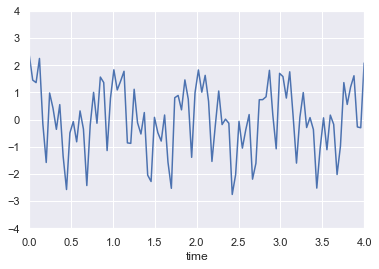

In [12]:
from scipy import fftpack

def fft_plot(a=1, b=1, c=1, fourier=True):
    np.random.seed(0)
    N = 100
    t_end = 4
    t = np.linspace(0, t_end, N)
    
    y = a*np.cos(2*np.pi*t) + b*np.sin(4*2*np.pi*t) + c*np.cos(8*2*np.pi*t) + 0.2*np.random.randn(N)
    Y = fftpack.fft(y)
    f = np.linspace(0, N, N)/t_end
    
    if fourier:
        plt.subplot(211)
        plt.plot(t, y)
        plt.xlim([0, 4])
        plt.ylim([-4, 4])
        plt.xlabel('time')
        
        plt.subplot(212)
        plt.plot(f, np.abs(Y)/len(Y))
        plt.ylim([0, 2])
        plt.xlabel('number of cyles in full window')
        plt.tight_layout()
    else:
        plt.plot(t, y)
        plt.xlim([0, 4])
        plt.ylim([-4, 4])
        plt.xlabel('time')

fft_plot(a=1, b=1, c=1, fourier=False);

From visual inspection, it is not apparent the frequencies that contribute to the signal but is derived from

$$ y(t) = a\cos(2\pi t) + b\sin(8\pi t) + c\cos(16\pi t) + \epsilon(t). $$

The signal is composed of three sines/cosines at frequencies of 1, 4, and 8 and random uncorrelated noise $\epsilon(t)$. The signal spans 4 time units and is sampled 25 times per unit of time. In the interactive visualization below, we display the signal and the resulting Fourier transform, allowing for the change in the amplitude of each of the three sinusoidal terms.

In [13]:
from ipywidgets import interact

interact(fft_plot, a=(0, 4, 0.1), b=(0, 4, 0.1), c=(0, 4, 0.1));

interactive(children=(FloatSlider(value=1.0, description='a', max=4.0), FloatSlider(value=1.0, description='b'…

One interpretation of the Fourier transform plot is that it is a histogram/distribution of the frequencies that contribute to the signal. The resulting graph has three peaks; each peak corresponds to a dominant frequency present in the signal. Notice how increasing the amplitude of one of the sinusoidal terms in the signal results in a larger value for the respective frequency in the Fourier transform plot.

The $x$-axis represents frequency, where the smallest non-zero frequency is equal to $1/t_{span}$ where $t_{span}$ is the size of the window or duration of the time series. The highest frequency is the inverse of the sampling rate.

**Questions**
* Are there any interesting features in the plot of the Fourier transform?
* What would happen if the magnitude of the noise increases? Would it be difficult to derive insight form the decomposed signal?

A Fourier transform of a real signal, no imaginary part, is symmetric about the center of the frequency range. The symmetric part is a result of _aliasing_, the effect of not differentiating two signals from each other. The discrete Fourier transform cannot measure the contribution of frequencies greater than the half of the inverse of the sampling rate, referred to as the Nyquist frequency,

$$ f_N = \frac{1}{2\Delta t}, $$

where $\Delta t$ is the sampling rate. In the visualization below, we display the sampled values of two signals, one below the Nyquist frequency and its higher frequency alias. The different signals have the same sampled values but are derived from different frequencies. Notice how the signal in green is too fast to properly measure with our sampling rate. During the time before the signal is sampled again, the curve has gone up (or down) and down (or up) and reached its max (or min) value. Given our sampling frequency, we cannot distinguish sampled data from the green curve from that of the blue curve, they are aliases of one another. Because of the aliasing effect, it is customary to only display the Fourier transform for frequencies less than the Nyquist, only the first half of the plot.

In [14]:
from ipywidgets import FloatSlider

def plot_alias(f=0.2, blue=True, green=True):
    t = np.linspace(0, 10, 500)
    t_sampled = np.arange(0, 11)
    
    if blue:
        plt.plot(t, np.sin(2*np.pi*f*t), 'b')
    if green:
        plt.plot(t, -np.sin(2*np.pi*(1-f)*t), 'g')
        
    l, m, b = plt.stem(t_sampled, np.sin(2*np.pi*f*t_sampled), linefmt='r', markerfmt='ro')
    plt.setp(b, visible=False)
    plt.ylim(-2, 2)
    plt.xticks(t_sampled)
    plt.legend(["f={}".format(f), "f={}".format(1-f), "sampled signal"])

interact(plot_alias, f=FloatSlider(min=0, max=1.0, step=0.05, value=0.05, description='$f$'));

interactive(children=(FloatSlider(value=0.05, description='$f$', max=1.0, step=0.05), Checkbox(value=True, des…

For the atmospheric CO2 data, let's formally identify the most dominant frequencies. We subtract the mean before computing the Fourier transform. If not, there would be a large value at zero frequency. The Fourier transform of the residuals is plotted below.

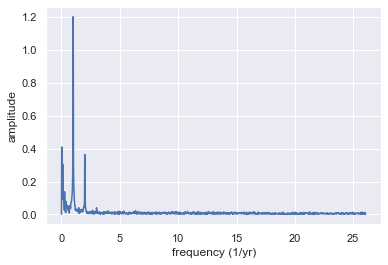

In [15]:
Y = fftpack.fft(resd-resd.mean())
t_span = CO2.index[-1] - CO2.index[0]
f = np.linspace(0, len(Y), len(Y))/t_span

plt.plot(f[:len(Y)//2], np.abs(Y[:len(Y)//2])/len(Y));
plt.xlabel('frequency (1/yr)')
plt.ylabel('amplitude');

It appears that there are no dominant frequencies greater than fives times a year. Let's zoom in for further inspection.

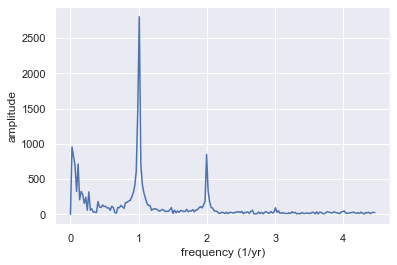

In [16]:
plt.plot(f[:200], np.abs(Y)[:200]);
plt.xlabel('frequency (1/yr)')
plt.ylabel('amplitude');

We see two dominant frequencies occurring at once and twice a year. Our updated baseline model is now

$$ y(t) = A + Bt + Ct^2 + D\sin(2\pi t) + E\cos(2\pi t) + F\sin(4\pi t) + G\cos(4\pi t), $$

where $t$ in expressed in units of years. To incorporate the seasonal components, we will construct a custom transformer and use a combination of pipelines and feature unions to construct our baseline model.

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

class FourierComponents(BaseEstimator, TransformerMixin):
    def __init__(self, freqs):
        """Create features based on sin(2*pi*f*t) and cos(2*pi*f*t)."""
        self.freqs = freqs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xt = np.zeros((X.shape[0], 2*len(self.freqs)))
        
        for i, f in enumerate(self.freqs):

            Xt[:, 2*i]= np.cos(2*np.pi*f*X).reshape(-1)
            Xt[:, 2*i + 1] = np.sin(2*np.pi*f*X).reshape(-1)
    
        return Xt

Test set R^2: 0.893036


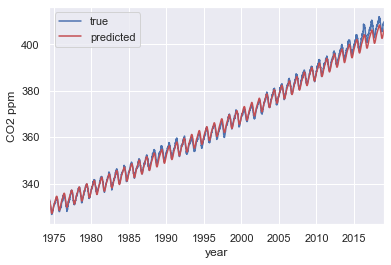

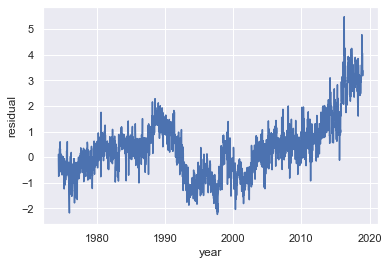

In [18]:
from sklearn.pipeline import FeatureUnion

# construct and train pipeline
fourier = FourierComponents([1, 2]) # annual and biannual frequencies
union = FeatureUnion([('drift', poly), ('fourier', fourier)])
baseline = Pipeline([('indices', time),
                 ('union', union),
                 ('regressor', lr)])
baseline.fit(df_train, y_train)

# make predictions
y_pred = baseline.predict(df)
resd = CO2 - y_pred
print("Test set R^2: {:g}".format(baseline.score(df_test, y_test)))
plot_results(df, y_pred)

At the moment, we have a baseline model that works well but the residuals do not appear to be completely stationary. Our analysis is not done, we can focus our attention on extracting any patterns in the resulting correlated noise.

**Questions**
* What, if any, behavior do you observe in the current baseline model's residuals?
* Instead of using $y(t) = A\cos(2\pi ft) + B\sin(2\pi t)$, we could have used the equivalent $y(t) = k\sin(2\pi ft - \phi). $ Why would the former be preferred?

*(q2) In both formulisations, we are fitting two parameters either way ( $A$&$B$ and $k$&$\phi$ ). However, for the former, we can easily solve for the Sine and Cosine components as **linear model separately** *

## Modeling noise

We can improve on our analysis by modeling the noise, the residuals of our baseline model. Specifically, we want to measure the persistence of past values on the signal. In other words, past values of our times series are correlated to current values. We expect there to be some correlation to past values but the persistence should die off for further values in the past. The **autocorrelation** will give us a measure the persistence of past values; it is a measure of how well correlated a signal is with a lag copy of itself. Let's define some important mathematical values that are crucial for understanding the autocorrelation.

* **Covariance**: A measure of _joint_ variability of two variables,
$$ \mathrm{cov}(X, Y) = E[(X - E[X])(Y - E[Y])] =  \frac{1}{N} \sum^{n}_{i=1}(x_i - E[X])(y_i - E[Y]). $$

* **Variance**: A measure of the variability of a variable with _itself_; the special case of the covariance,
$$ \mathrm{var}(X) =  \mathrm{cov}(X, X) = E[(X - E[X])^2] = \frac{1}{N} \sum^{n}_{i=1}(x_i - E[X])^2. $$ 

* **Standard Deviation**: The square root of the variance,
$$ \sigma_X = \sqrt{\mathrm{var}(X)}. $$

* **Correlation**: The normalized covariance that ranges from -1 to to 1,
$$\rho(X, Y) = \frac{\mathrm{cov}(X, Y)}{\sigma_X \sigma_Y}. $$ 

Three important values and meanings of the correlation coefficient are:

1. If $\rho(X, Y) = 1$, then the two variables are completely linear correlated; an increase in one corresponds to a linear increase of the other.
1. If $\rho(X, Y) = 0$, then the two variables are uncorrelated. Higher values of one variable does not necessarily correspond to higher or lower values of the other.
1. If $\rho(X, Y) = -1$, then the two variables are completely linear anti-correlated; an increase in one corresponds to a linear decrease of the other.

With the correlation coefficient, we can now mathematically define and better understand the autocorrelation of a signal. The autocorrelation as a function of the duration of the lag is defined as

$$ R(\tau) =  \frac{\mathrm{cov}(y(t), y(t-\tau))}{\sigma_{y} \sigma_{y}} = \frac{\gamma(\tau)}{\sigma^2_{y}} = \rho(y(t), y(t-\tau)), $$

where $\tau$ is the duration of the lag/delay and $\gamma$ is the autocovariance function. Since we are working with discrete data, we can define the lag with respect to the number of time steps $k$,

$$ R(k) = \frac{\gamma(k)}{\sigma_{y}^2} = \rho(y_t, y_{t-k}). $$

Since the autocorrelation is a measure of how correlated a signal is with a delayed copy of itself, plotting the autocorrelation function will reveal to us how correlated past values are. The pandas function `autocorrelation_plot` plots the autocorrelation function of the curve and includes 95% and 99% confidence values of the zero-correlation hypothesis. The point of interest in the curve is at what lag value is there no more correlation. Such value is the characteristic time scale of the process.

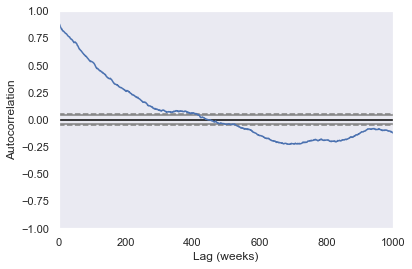

In [19]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(resd)
plt.xlabel('Lag (weeks)')
plt.xlim([0, 1000]);

It appears that values past 400 to 500 weeks are not correlated with current values.

## Noise based feature generation

With the noise/residual of our time series, we can generate features based on past values for each time step. These features can be

* Statistics of a window of past values, such as the mean and max. 
* One hot encoded features based on things such as the days of the week and holidays.
* External features for each time step, for example, the value of the stock market.

After determining the characteristic time scale of our process, we can incorporate the time scale when deciding how to best generate features. A common statistic to calculate is the moving average. For a times series, the moving average of a point in time is some average value calculated using a subset of past values. There are different types of moving averages but two common ones are:

* **Rolling Window Average**: The average is calculated for a window of $k$ previous points.

$$ MA_t = \frac{1}{k} \sum^{n}_{n-k} y_k. $$

* **Exponential Moving Average**: All points are included in calculating the average but are weighted using an exponential decay. In other words, values further in the past contribute less to the moving average than recent points. A nice property of the exponential moving average is that the moving average value can be calculated with only the current time series value and the previous exponential moving average value.

$$ EMA_t = \alpha y_t + (1 - \alpha) EMA_{t-1}, $$

where $\alpha$ ranges from 0 to 1 and scales the strength of the contribution of past values. The value of $\alpha$ is related to the half-life of the weights, the time for the weights to drop half of their value,

$$ \alpha = 1 - \exp\left[-\frac{\ln(2)}{t_{1/2}}\right], $$

where $t_{1/2}$ is the half-life. Note, while we have discussed rolling window and exponential moving _averages_, other values can be calculated for other statistics. 

In the visualizations below, you can control the window size and half-life of the rolling window and exponentially weighted average of the residuals. Notice how applying moving averages smooths out the residuals. These moving averages are sometimes used to smooth out data.

In [20]:
def plot_rolling_window(window=10):
    series = pd.Series(resd, index=df.index)

    rolling_window = series.rolling(window=window).mean()
    series.plot(alpha=0.5)
    rolling_window.plot(linewidth=2, color='k')
    plt.title('rolling window')
    plt.xlabel('year')
    plt.ylabel('moving average')
    
interact(plot_rolling_window, window=(1, 200, 1));

interactive(children=(IntSlider(value=10, description='window', max=200, min=1), Output()), _dom_classes=('wid…

In [21]:
def plot_exponential_weighted(half_life=100):
    series = pd.Series(resd, index=df.index)
    exponential_weighted = series.ewm(halflife=half_life).mean()
    
    series.plot(alpha=0.5)
    exponential_weighted.plot(linewidth=2, color='k')
    plt.title('exponential weighted')
    plt.xlabel('year')
    plt.ylabel('moving average')

half_life_slider = FloatSlider(min=1, max=100, step=0.1, value=10, description="half-life")
interact(plot_exponential_weighted, half_life=half_life_slider);

interactive(children=(FloatSlider(value=10.0, description='half-life', min=1.0), Output()), _dom_classes=('wid…

**Questions**
* How does one determine a good value to use for window size or half-life?
* Considering computer memory, what moving average is better to use, rolling window average or exponential moving average?
* How does increasing the half-life affect $\alpha$?

- *(q1) We are essential asking, how many of the past points should i consider? So, if we had to consider the Autocorrelation plot, this can be a guide and choose a window of up to a past where the corr coeff is 0. In this case it would be up to a max 400-500*
- *(q2) in terms of memory,*
    - *the Rolling Window would need to remeber k (window size) sample*
    - *for Exponential Moving Average, we only need current time series value $y_t$ and the past exponential moving average value $EMA_{t_1}$*
- *(q3) As $\alpha -> 1$, the decay is much larger and the contribution from older components takes longer. On the other hand, for $\alpha -> 0$, the weights of the old weights is still large so their contibution is significant*


With a baseline model and resulting residuals, our goal is to construct a model to predict atmospheric CO2 levels 20 weeks into the future. In other words, given the time series values we have currently measured at time $t$, we want to predict or forecast the value of the time series 20 time steps into the future since we sample the data weekly. For our approach, we will use the current time step residual, the prior residual, the rolling mean of the residual, and the rolling mean of the difference of the residual to predict the residual 20 weeks later. For the rolling window, we will choose a window size of 100 weeks.

In [22]:
class ResidualFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, window=100):
        """Generate features based on window statistics of past noise/residuals."""
        self.window = window
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = pd.DataFrame()
        df['residual'] = pd.Series(X, index=X.index)
        df['prior'] = df['residual'].shift(1)
        df['mean'] = df['residual'].rolling(window=self.window).mean()
        df['diff'] = df['residual'].diff().rolling(window=self.window).mean()
        df = df.fillna(method='bfill') # any missing values are filled in backwards
        
        return df

In [23]:
from sklearn.metrics import r2_score

# create and train residual model
resd_train = y_train - baseline.predict(df_train)
residual_feats = ResidualFeatures(window=100)
residual_model = Pipeline([('residual_features', residual_feats), ('regressor', LinearRegression())])
residual_model.fit(resd_train.iloc[:-20], resd_train.shift(-20).dropna())

# evaluate model
resd_pred = residual_model.predict(resd) # prediction for all time steps
resd_pred = pd.Series(resd_pred, index=df.index)
resd_pred = resd_pred.shift(20).dropna() # shift predicted values to matching time step
resd_pred_test = resd_pred.loc[resd_pred.index > 2010] # evaluate only on 2010 values
print("Residual test set R^2: {:g}".format(r2_score(resd.loc[resd.index > 2010], resd_pred_test)))

Residual test set R^2: 0.442194


Now with the residual model, we can combine both the baseline and residual model to make forecasts of atmospheric CO2 levels. It is best to create a custom estimator to encapsulate the process of combining both models.

Test set R^2: 0.983669


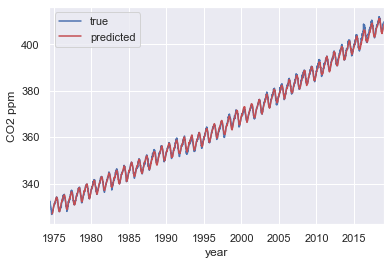

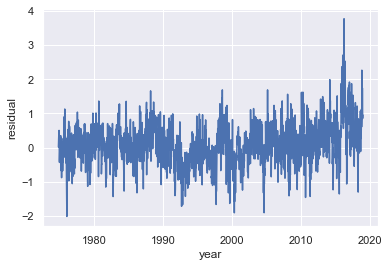

In [24]:
from sklearn.base import RegressorMixin

class FullModel(BaseEstimator, RegressorMixin):
    def __init__(self, baseline, residual_model, steps=20):
        """Combine a baseline and residual model to predict any number of steps in the future."""
        
        self.baseline = baseline
        self.residual_model = residual_model
        self.steps = steps
        
    def fit(self, X, y):
        self.baseline.fit(X, y)
        resd = y - self.baseline.predict(X)
        self.residual_model.fit(resd.iloc[:-self.steps], resd.shift(-self.steps).dropna())
                
        return self
    
    def predict(self, X):
        y_b = pd.Series(self.baseline.predict(X), index=X.index)
        resd = X['molfrac'] - y_b
        resd_pred = pd.Series(self.residual_model.predict(resd), index=X.index)
        resd_pred = resd_pred.shift(self.steps)
        y_pred = y_b + resd_pred
        
        return y_pred
    
# construct and train full model
full_model = FullModel(baseline, residual_model, steps=20)
full_model.fit(df_train, y_train)

# make predictions
y_pred = full_model.predict(df)
resd = CO2 - y_pred
ind = resd.index > 2010
print("Test set R^2: {:g}".format(r2_score(CO2.loc[ind], y_pred.loc[ind])))
plot_results(df, y_pred)

Our final model works really well at making predictions 20 weeks into the future. Let's plot the histogram and autocorrelation of the final residuals.

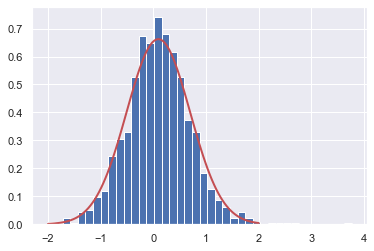

In [41]:
from scipy.stats import norm

mu = resd.mean()
sigma = resd.std(ddof=1)
dist = norm(mu, sigma)
x = np.linspace(-2, 2, 100)
f = dist.pdf(x)

resd.hist(bins=40, density=True)
plt.plot(x, f, '-r', linewidth=2);

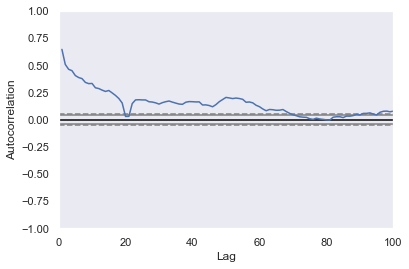

In [42]:
autocorrelation_plot(resd.dropna())
plt.xlim([0, 100]);

The residuals are Gaussian and while arguably past values are still correlated, they are not as correlated as they were before.

## Statistical time series models

There are a class of statistically based models for time series. Most of these models are provided by the `statsmodels` Python package. Unfortunately, the API of models are different than `scikit-learn`. For this section, we will briefly discuss these models and demonstrate their usage in Python.

### Autoregressive and moving average models

The autoregressive (AR) model of order $p$ states that the current time series value is linearly dependent on the past $p$ values with some white noise,

$$y_t = c + \alpha_1 y_{t-1} + \alpha_2 y_{t-2} + ... \alpha_p y_{t-p} + \epsilon_t = c + \sum^{p}_{p=1} \alpha_p y_{t-p} + \epsilon_t, $$

where $\alpha_p$ are the model parameters, $y_{t-p}$ are past time series values, $c$ is a constant, and $\epsilon_t$ is white noise. The name autoregressive refers to the model parameters being solved by applying regression with the time series values themselves. Our previous illustration discussing stationary signals is an autoregressive model of order one as the current value is equal to the scaled prior value plus some noise. Autoregressive models are great at capturing the mean reversion and momentum in the time series since it is based on a window of past values.

Another model is the moving average (MA) model. Despite similar names, the MA model and concept of moving averages are different and should not be confused. The MA model of order $q$ says that the time series is linearly dependent on current and past shock values or noise,

$$y_t = c + \epsilon_t + \beta_1 \epsilon_{t-1} + \beta_2 \epsilon_{t-2} + ... \beta_q \epsilon_{t-q} = c + \sum^{q}_{q=1} \beta_q \epsilon_{t-q} + \epsilon_t, $$

where $\beta_q$ are the model parameters. The MA model captures the persisting effect of shock events on future time series values. To get the capabilities of both models, AR and MA models are added, forming a more general time series model referred to as autoregressive and moving average (ARMA) model. The coefficients of the AR models are solved using a variety of methods such as linear least squares regression. MA coefficients are more computationally intensive to solve because shock values are not directly observed, requiring non-linear fitting algorithms. When using ARMA, the order of both AR and MA need to be specified and can be different.

**Question**
* How should one identify an appropriate value for the order of either AR and MA?

*(Q) Choose a number of past values whcih lie within the first zero crossing on the auto correlation plot*

Let's demonstrate the AR model from `statsmodels` for forecasting the residuals of the baseline model.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


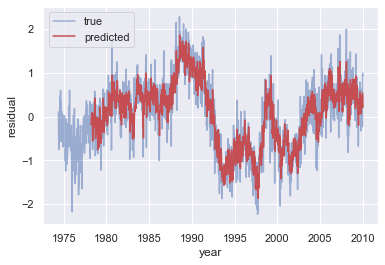

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


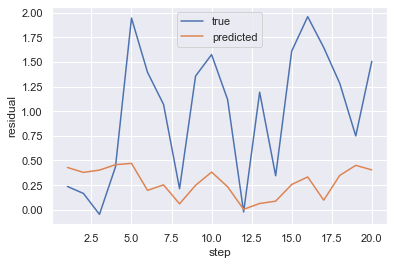

In [64]:
from statsmodels.tsa.ar_model import AR

# create and fit AR model
lag = 200
resd_train = y_train - baseline.predict(df_train)

ar = AR(resd_train.values, dates=df_train['date'], freq='W')
ar = ar.fit(maxlag=lag)
resd_ar_train_pred = ar.predict(start=lag, end=len(df_train)-1)

# plot training set results
plt.plot(df_train.index, y_train - baseline.predict(df_train), alpha=0.5)
plt.plot(df_train.index[lag:], resd_ar_train_pred, 'r')
plt.xlabel('year');
plt.ylabel('residual')
plt.legend(['true', 'predicted'])
plt.show();

# plot 20 step forecast of test set
steps = 20
resd_ar_test_pred = ar.predict(start=len(df_train), end=len(df_train) + steps - 1)
plt.plot(range(1, steps + 1), y_test.iloc[:steps] - baseline.predict(df_test.iloc[:steps]))
plt.plot(range(1, steps + 1), resd_ar_test_pred)
plt.xlabel('step')
plt.ylabel('residual')
plt.legend(['true', 'predicted']);

The general syntax for using the models from `statsmodels` is passing the training data when instantiating the model, fitting the model by passing the number of terms to include, and finally calling the `predict` method with the number of steps into the future to forecast. The AR model was able to capture the trends, the ups and downs, of the residuals but under predicted the magnitude of those trends.

## ARIMA

The ARMA model only works for a stationary process. One method to arrive at a stationary process is to apply a difference transformation, $\Delta y_t = y_t - y_{t-1}$. In our example of a random walk, the series was not stationary but the time series of the difference is stationary because it only depends on white Gaussian noise. The autoregressive integrated moving average (ARIMA) model is a general form of ARMA that applies differencing to the time series in the **hopes of generating a stationary process**. The ARIMA model is often written as $\mathrm{ARIMA}(p, d, q)$, where
* $p$: Number of terms to include in the AR model.
* $d$: The degree of differencing, how many times differencing is applied to the series.
* $q$: Number of terms to include in the MA model.

Let's use the ARIMA model provided by the `statsmodels` package on the noise/residual of Mauna Loa data. Since the model takes a long time to fit, we have provided a pickle file of the trained model.

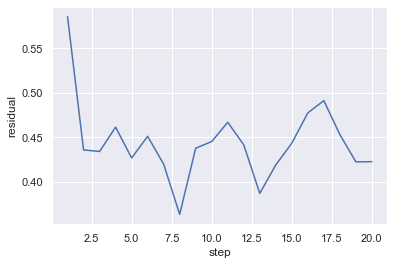

In [65]:
import pickle
from statsmodels.tsa.arima_model import ARIMA

# arima = ARIMA(resd_train.values, order=(20, 1, 5), dates=df_train['date'], freq='W')
# arima = arima.fit()

# load pretrained model
with open('data/arima_model.pkl', 'rb') as f:
    arima = pickle.load(f)

# plot 20 step forecast of test set
steps = 20
resd_arima_test_pred, _, _ = arima.forecast(steps)
plt.plot(range(1, steps + 1), resd_arima_test_pred)
plt.xlabel('step')
plt.ylabel('residual');

In [66]:
def generate_ts(rho):
    '''Generate a time series of the following form y_t = rho_0*y_t + tho_1*y_t-2 + eps'''
    n = 1000
    
    eps = 0.1*np.random.randn(n)
    y = np.zeros(n)
    y[0] = eps[0]
    
    for i in range(1,n):
        y[i] = rho[0]*y[i-1] + eps[i]
        
        if i > 1:
            y[i] = y[i]  + rho[1]*y[i-2]
    
    return y

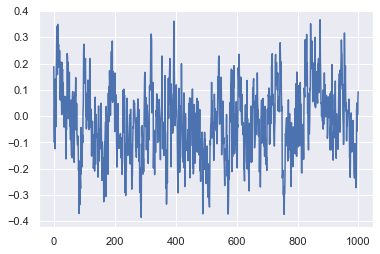

In [67]:
y = generate_ts((0.5,0.25))
plt.plot(y)

In [68]:
from statsmodels.tsa.ar_model import  AR
ar = AR(y)
ar  = ar.fit(maxlag=2)

In [69]:
ar.params

array([-0.0053277 ,  0.47763377,  0.26724429])

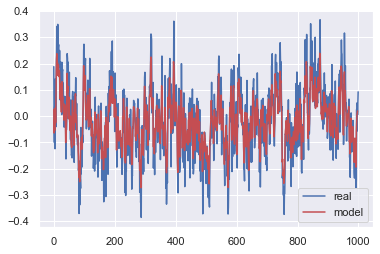

In [70]:
plt.plot(y, label='real')
plt.plot(ar.predict(), 'r',label = 'model')
plt.legend()
plt.show()

In [71]:
ar = AR(y)
ar  = ar.fit() #removing maxlag defaults to 22 lag params
ar.params

array([-0.00596296,  0.46491524,  0.25777776,  0.04528964, -0.06045236,
       -0.02379726, -0.00555197,  0.10555543, -0.02215174,  0.02108907,
       -0.04180384, -0.02729331,  0.01001813,  0.04165129,  0.00711787,
       -0.01501053,  0.00293005,  0.02566805, -0.01680945,  0.00525095,
        0.01304472, -0.01726025])

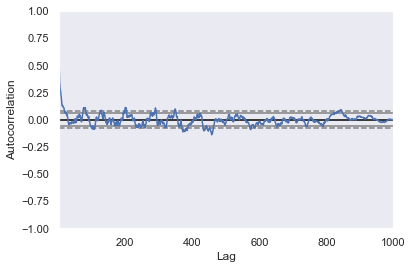

In [73]:
autocorrelation_plot(y);

(0, 12)

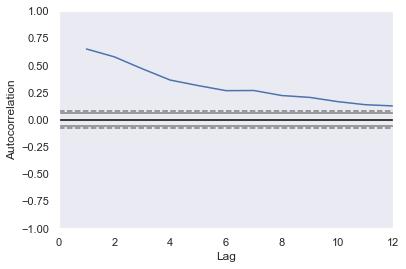

In [74]:
autocorrelation_plot(y)
plt.xlim([0,12])
# plot indicates we should not use more than 10

In [75]:
ar = AR(y)
ar  = ar.fit(maxlag=10)
ar.params

array([-0.00514114,  0.47069211,  0.26275334,  0.04553536, -0.06420027,
       -0.01149297, -0.00331918,  0.10264671, -0.02212159,  0.00959516,
       -0.02137709])

choosing less order, it is less likely to overfit

## Exercises

1. Incorporate more features into the residual model. Consider including more window statistics and external features such as financial data. Measure the performance in both the residual and full model.
1. Since we have relatively small number of features, we were not worried about overfitting with the residual model using linear regression. However, overfitting becomes a problem with more features and more complicate models. Chose a different model than linear regression and tune the model's hyperparameters. You may need to use `TimeSeriesSplit` in conjunction with `GridSearchCV` to properly tune the model.
1. Use the full model to predict atmospheric CO2 levels for the first 20 weeks of 2019. Check to see how well the model performs once data has been made available.
1. Practice using the AR model available in `statsmodels` by generating a time series in the form of $y_t = \rho y_{t-1} + \epsilon_t$. Compare the fitted AR model coefficient(s) to the chosen value of $\rho$. The fitted AR model coefficients are stored in the `params` attribute.
1. Using either AR, MA, ARMA, or ARIMA for the residual model when forecasting atmospheric CO2 levels.